# Q2: PART (E): Conduct ablation study with cycle-consistency loss in CycleGAN

In this part, an ablation study is conducted on the impact of the cycle-consistency loss. In Part (B) you implemented cycle-consistency loss which consists of forward-consistency (from distribution A to B) and backward-consistency (from distribution B to A). In this part, you will conduct an ablation study examining the generator performance when only having one of the two cycle-consistency losses. For your intuition, consider the cycle-consistency loss function.

$$\mathcal{L}_{cyc}(G_{AB}, G_{BA}) = \mathcal{L}_{forward}(G_{AB}) + \mathcal{L}_{backward}(G_{BA})$$
where 
\begin{align*}
\mathcal{L}_{forward}(G_{AB}, G_{BA}) &= \mathbb{E}_{a \sim p_{data}(a)}\left[||G_{BA}(G_{AB}(a))-a||_1\right] \\
\mathcal{L}_{backward}(G_{AB},G_{BA}) &= \mathbb{E}_{b \sim p_{data}(b)}\left[||G_{AB}(G_{BA}(b))-b||_1\right]
\end{align*}

In [1]:
# Load the necessary imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from library import datasets, models
from library.utils.helper_functions import plot_samples, plot_reconstructed_samples
from flax import linen as nn
from jax import random
import optax
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

## Dataset

This notebook also uses the blob dataset, but for this part dataset A and B will have different numbers of blobs. A will have two blobs and B will have one blob, see the vizualisation below for clarification.

In [2]:
key = random.PRNGKey(5)
key_A, key_B = random.split(key)

# Create dataset
A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B, n_clusters=1)

real_A = A.get_tensors()
real_B = B.get_tensors()

In [3]:
plot_samples(real_A, real_B)

## Initialize CycleGAN and interpret generated fake samples

Since you already learned how to create the discriminator and generator in the GAN notebook, you can reuse their architectures below. Remember that we have two different distributions now instead of one for GAN.

In [4]:
# Define ambient dimension, discriminator and generator
AMBIENT_DIM = 2

discriminator_A = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

discriminator_B = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1),
])

generator_AB = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])

generator_BA = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM),
])


In [5]:
# Initialize model with generators, discriminators and loss function.
modules = {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    }

model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [6]:
gan_AB, gan_BA = model.create_distribution()
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))

plot_reconstructed_samples(real_A, real_B, recon_A, recon_B)

## Train with bidirectional cycle loss

To compare the results of using unidirectional losses, the CycleGAN is first trained with both the forward-consistency and backward-consistency.

In [7]:
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [8]:
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_, cycle_loss_mask = 'None')

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7575; B->A->B cycle loss:  0.7845; A->B->A cycle loss:  0.8255; Discriminator A loss:  0.6589; Discriminator B loss:  0.7475: : 1it [00:02,  2.66s/it]
Epoch 1; Generator AB GAN loss:  0.6932; Generator BA GAN loss:  0.7817; B->A->B cycle loss:  0.7418; A->B->A cycle loss:  0.8256; Discriminator A loss:  0.6475; Discriminator B loss:  0.7357: : 1it [00:00,  6.92it/s]
Epoch 2; Generator AB GAN loss:  0.6889; Generator BA GAN loss:  0.8082; B->A->B cycle loss:  0.6991; A->B->A cycle loss:  0.8219; Discriminator A loss:  0.6344; Discriminator B loss:  0.7249: : 1it [00:00,  6.92it/s]
Epoch 3; Generator AB GAN loss:  0.6858; Generator BA GAN loss:  0.8393; B->A->B cycle loss:  0.6479; A->B->A cycle loss:  0.8198; Discriminator A loss:  0.6198; Discriminator B loss:  0.7149: : 1it [00:00,  6.90it/s]
Epoch 4; Generator AB GAN loss:  0.6835; Generator BA GAN loss:  0.8758; B->A->B cycle loss:  0.5898; A->B->A cycle loss:  0.819

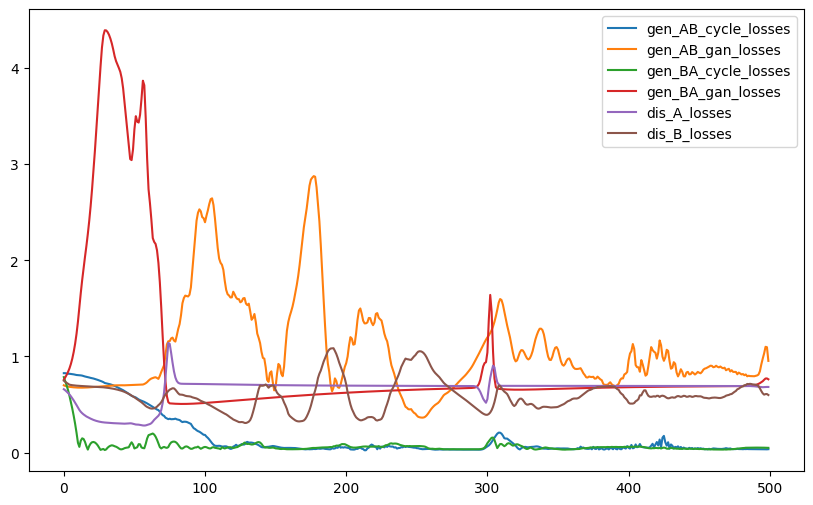

In [9]:
fig = plt.figure(figsize=(10, 6))

for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)

plt.legend()
plt.show()

In [10]:
gan_AB, gan_BA = model.create_distribution()
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))

plot_reconstructed_samples(real_A, real_B, recon_A, recon_B)

## Train with unidirectional cycle loss

Now, it is time to explore the use of unidirectional cycle loss. The CycleGAN is first trained using only the forward-consistency loss, and then using only the backward-consistency loss.

### Train with ABA cycle loss only

In [11]:
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [12]:
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_, cycle_loss_mask = 'BAB')

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7575; B->A->B cycle loss:  0.7845; A->B->A cycle loss:  0.8255; Discriminator A loss:  0.6589; Discriminator B loss:  0.7475: : 1it [00:01,  1.42s/it]
Epoch 1; Generator AB GAN loss:  0.6921; Generator BA GAN loss:  0.7651; B->A->B cycle loss:  0.8123; A->B->A cycle loss:  0.8220; Discriminator A loss:  0.6550; Discriminator B loss:  0.7360: : 1it [00:00,  6.93it/s]
Epoch 2; Generator AB GAN loss:  0.6883; Generator BA GAN loss:  0.7723; B->A->B cycle loss:  0.8239; A->B->A cycle loss:  0.8212; Discriminator A loss:  0.6516; Discriminator B loss:  0.7250: : 1it [00:00,  7.01it/s]
Epoch 3; Generator AB GAN loss:  0.6860; Generator BA GAN loss:  0.7776; B->A->B cycle loss:  0.8258; A->B->A cycle loss:  0.8155; Discriminator A loss:  0.6480; Discriminator B loss:  0.7149: : 1it [00:00,  6.96it/s]
Epoch 4; Generator AB GAN loss:  0.6839; Generator BA GAN loss:  0.7810; B->A->B cycle loss:  0.8294; A->B->A cycle loss:  0.811

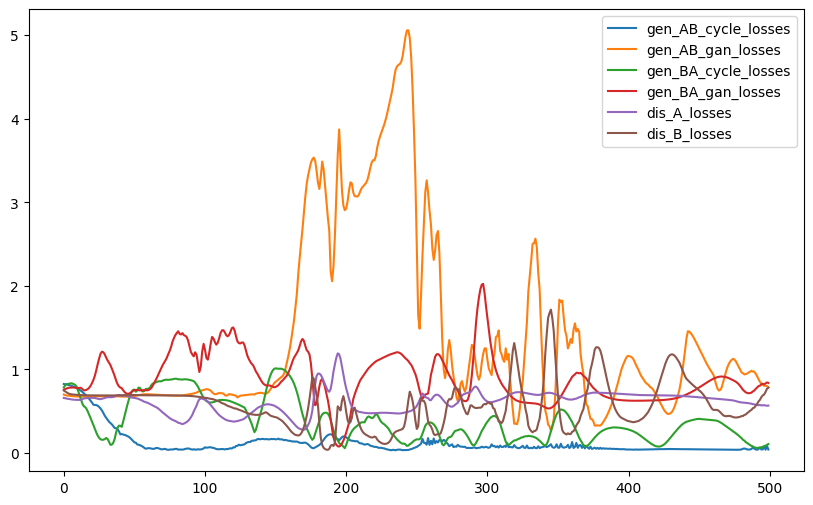

In [13]:
fig = plt.figure(figsize=(10, 6))

for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)

plt.legend()
plt.show()

In [14]:
gan_AB, gan_BA = model.create_distribution()
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))
plot_reconstructed_samples(real_A, real_B, recon_A, recon_B)

### Train with BAB cycle loss only

In [15]:
model = models.cyclegan.CycleGAN(modules, (AMBIENT_DIM,), (AMBIENT_DIM,))
model.initialize(optax.sigmoid_binary_cross_entropy)

In [16]:
lambda_ = 5
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=lambda_, cycle_loss_mask = 'ABA')

Epoch 0; Generator AB GAN loss:  0.6995; Generator BA GAN loss:  0.7575; B->A->B cycle loss:  0.7845; A->B->A cycle loss:  0.8255; Discriminator A loss:  0.6589; Discriminator B loss:  0.7475: : 1it [00:01,  1.65s/it]
Epoch 1; Generator AB GAN loss:  0.6931; Generator BA GAN loss:  0.7817; B->A->B cycle loss:  0.7418; A->B->A cycle loss:  0.8263; Discriminator A loss:  0.6475; Discriminator B loss:  0.7358: : 1it [00:00,  5.98it/s]
Epoch 2; Generator AB GAN loss:  0.6888; Generator BA GAN loss:  0.8080; B->A->B cycle loss:  0.6999; A->B->A cycle loss:  0.8252; Discriminator A loss:  0.6345; Discriminator B loss:  0.7249: : 1it [00:00,  6.35it/s]
Epoch 3; Generator AB GAN loss:  0.6859; Generator BA GAN loss:  0.8384; B->A->B cycle loss:  0.6493; A->B->A cycle loss:  0.8245; Discriminator A loss:  0.6202; Discriminator B loss:  0.7149: : 1it [00:00,  5.37it/s]
Epoch 4; Generator AB GAN loss:  0.6836; Generator BA GAN loss:  0.8743; B->A->B cycle loss:  0.5914; A->B->A cycle loss:  0.823

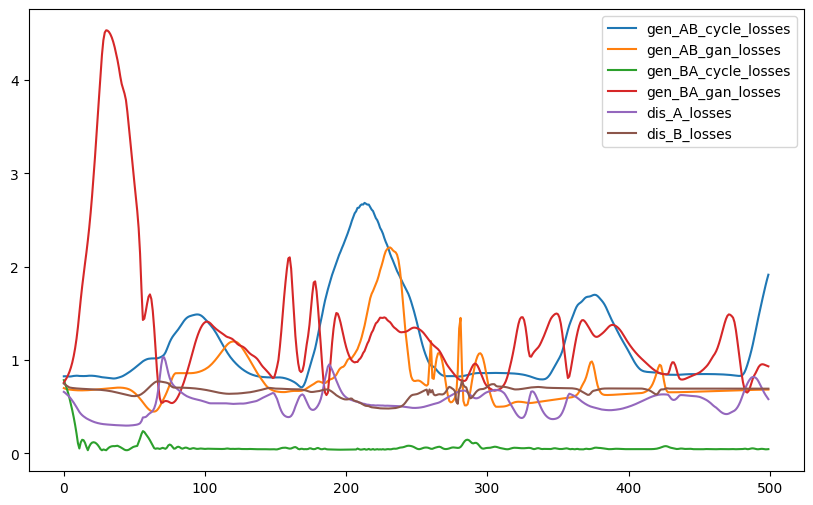

In [17]:
fig = plt.figure(figsize=(10, 6))

for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)

plt.legend()
plt.show()

In [18]:
gan_AB, gan_BA = model.create_distribution()
recon_A = gan_BA.generator(gan_AB.generator(real_A))
recon_B = gan_AB.generator(gan_BA.generator(real_B))
plot_reconstructed_samples(real_A, real_B, recon_A, recon_B)

**Q. Compare the $A \rightarrow B \rightarrow A$ cycle loss when training with only $B \rightarrow A \rightarrow B$, and the $B \rightarrow A \rightarrow B$ cycle loss when training with only $A \rightarrow B \rightarrow A$ cycle loss. Which one is larger?**

Write your answers in the written portion.